# Laboratorio 4 - Data Science
## Integrantes:
### Mario Guerra - 21008
### Javier Alvarado - 21188

## Análisis Exploratorio

In [9]:
#!pip install numpy pandas matplotlib seaborn tensorflow scikit-learn

  Using cached scikit_learn-1.5.1-cp311-cp311-win_amd64.whl.metadata (12 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.1-cp311-cp311-win_amd64.whl (11.0 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/44.8 MB 3.4 MB/s eta 0:00:14
   -- ------------------------------------- 2.6/44.8 MB 7.6 MB/s eta 0:00:06
   --- ------------------------------------ 4.5/44.8 MB 7.9 MB/s eta 0:00:06
   ------ --------------------------------- 6.8/44.8 MB 9.1 MB/s eta 0:00:05
   ------- -------------------------------- 8.4/44.8 MB 8.7 MB/s eta 0:00:05
   -------- ------------------------------- 9.4/44.8 MB 7.8 MB/s eta 0:00:05
   --------- ------------------------------ 11.0/44.8 MB 7.9 MB/s eta 0:00:05
   ----------- ---------------------------- 12.6/44.8 MB 7.9 

In [2]:
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import numpy as np
import seaborn as sns

from os import listdir
import shutil
import numpy as np
import keras.preprocessing.image as kerasImg
import keras.layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import ops

In [3]:
def load_data(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                image = load_img(file_path, color_mode='grayscale')
                image = img_to_array(image)
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

# Cargar datos de entrenamiento y prueba
train_dir = 'PolyMNIST/MMNIST/train'
test_dir = 'PolyMNIST/MMNIST/test'

train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

print(f'Train Images Shape: {train_images.shape}')
print(f'Train Labels Shape: {train_labels.shape}')
print(f'Test Images Shape: {test_images.shape}')
print(f'Test Labels Shape: {test_labels.shape}')


Train Images Shape: (300000, 28, 28, 1)
Train Labels Shape: (300000,)
Test Images Shape: (50000, 28, 28, 1)
Test Labels Shape: (50000,)


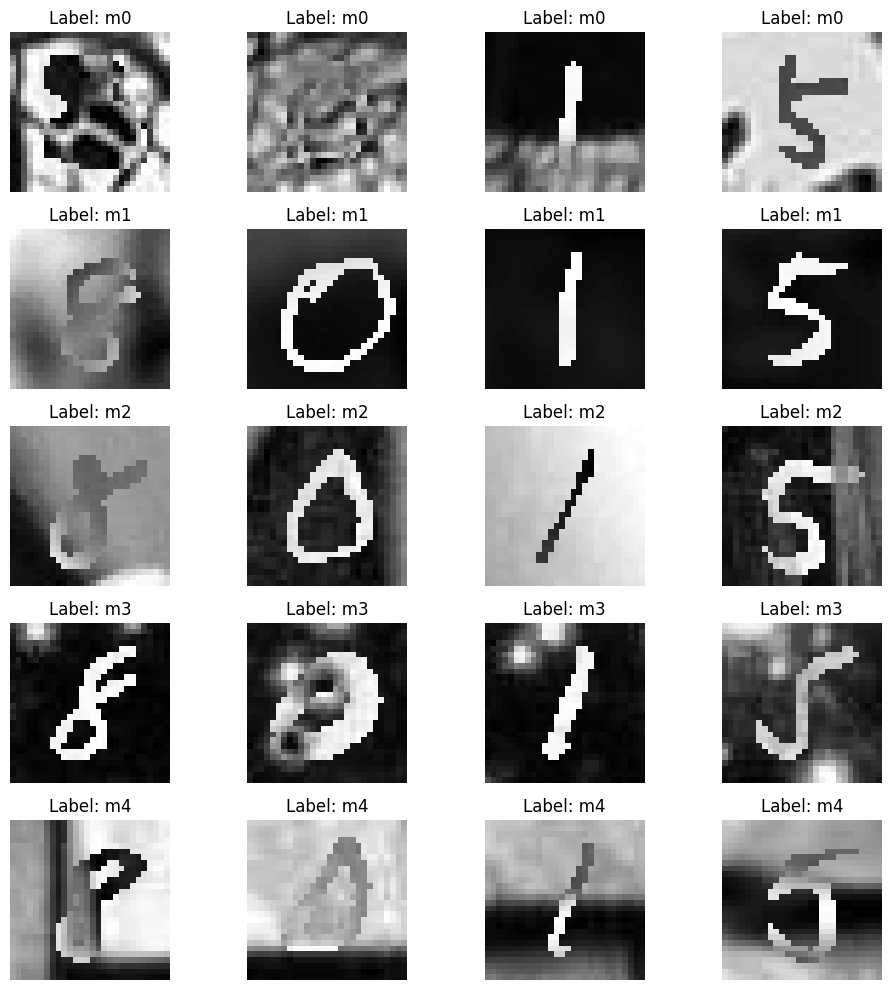

In [4]:
# Convertir etiquetas y datos a un DataFrame para filtrar por cada clase
train_df = pd.DataFrame({'image': list(train_images), 'label': train_labels})

# Mostrar algunas imágenes del dataset de entrenamiento para las etiquetas m1, m2, m3, y m4
plt.figure(figsize=(10, 10))

for i, label in enumerate(['m0', 'm1', 'm2', 'm3', 'm4']):
    # Filtrar imágenes por etiqueta
    filtered_df = train_df[train_df['label'] == label].sample(4, random_state=42)
    
    for j, img in enumerate(filtered_df['image']):
        plt.subplot(5, 4, i * 4 + j + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')

plt.tight_layout()
plt.show()

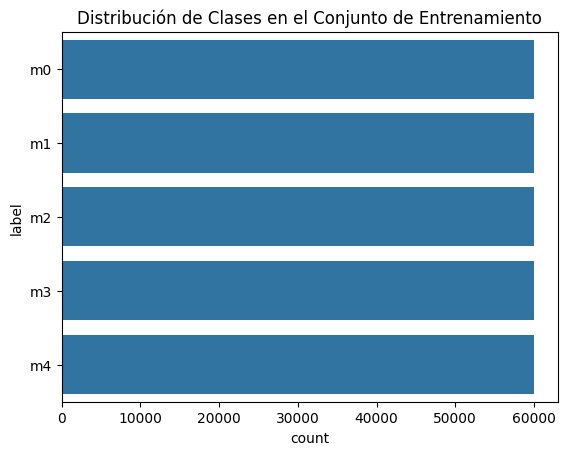

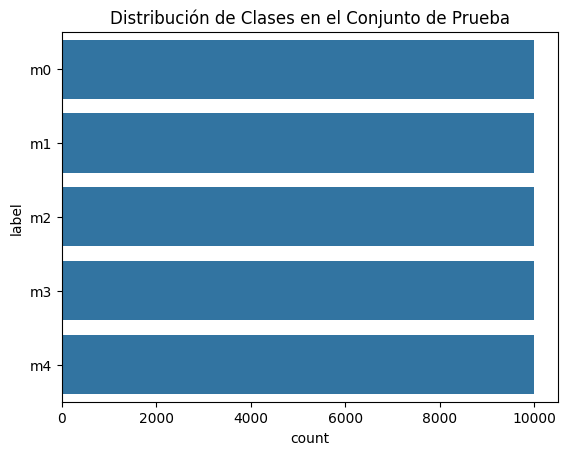

In [5]:
# Convertir etiquetas a DataFrame para facilitar la visualización
train_labels_df = pd.DataFrame(train_labels, columns=['label'])
test_labels_df = pd.DataFrame(test_labels, columns=['label'])

# Visualizar la distribución de las clases
sns.countplot(train_labels_df['label'])
plt.title("Distribución de Clases en el Conjunto de Entrenamiento")
plt.show()

# Visualizar la distribución de las clases
sns.countplot(test_labels_df['label'])
plt.title("Distribución de Clases en el Conjunto de Prueba")
plt.show()


In [6]:
# Verificar la resolución de las imágenes
resolution = train_images[0].shape
print(f'Resolución de las Imágenes: {resolution[0]}x{resolution[1]} píxeles')


Resolución de las Imágenes: 28x28 píxeles


In [7]:
# Contar la cantidad de cada etiqueta
train_class_distribution = train_labels_df['label'].value_counts().to_dict()
test_class_distribution = test_labels_df['label'].value_counts().to_dict()
print(f'Distribución de Clases: {test_class_distribution}')
print(f'Distribución de Clases: {test_class_distribution}')


Distribución de Clases: {'m0': 10000, 'm1': 10000, 'm2': 10000, 'm3': 10000, 'm4': 10000}
Distribución de Clases: {'m0': 10000, 'm1': 10000, 'm2': 10000, 'm3': 10000, 'm4': 10000}


## Creación de modelos de Deep Learning (CNN)

In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Normalizar imágenes
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Codificar etiquetas a números
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convertir etiquetas a one-hot encoding
train_labels_one_hot = to_categorical(train_labels_encoded)
test_labels_one_hot = to_categorical(test_labels_encoded)


# Modelo 1: CNN Básico

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_basic_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(train_images.shape[1], train_images.shape[2], 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

basic_cnn = create_basic_cnn()


c:\Users\mague\Downloads\Lab4DataScience\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Modelo 2: CNN Avanzado

In [12]:
from tensorflow.keras.layers import Dropout

def create_advanced_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(train_images.shape[1], train_images.shape[2], 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

advanced_cnn = create_advanced_cnn()

In [13]:
# Entrenamiento del modelo básico
history_basic = basic_cnn.fit(train_images, train_labels_one_hot, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluación del modelo básico
test_loss_basic, test_accuracy_basic = basic_cnn.evaluate(test_images, test_labels_one_hot, verbose=1)
print(f'Accuracy del Modelo Básico: {test_accuracy_basic:.4f}')

# Entrenamiento del modelo avanzado
history_advanced = advanced_cnn.fit(train_images, train_labels_one_hot, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluación del modelo avanzado
test_loss_advanced, test_accuracy_advanced = advanced_cnn.evaluate(test_images, test_labels_one_hot, verbose=1)
print(f'Accuracy del Modelo Avanzado: {test_accuracy_advanced:.4f}')


Epoch 1/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 243s 32ms/step - accuracy: 0.7939 - loss: 0.4849 - val_accuracy: 0.0000e+00 - val_loss: 15.4943
Epoch 2/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - accuracy: 0.9527 - loss: 0.1317 - val_accuracy: 0.0000e+00 - val_loss: 26.6097
Epoch 3/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 195s 26ms/step - accuracy: 0.9680 - loss: 0.0893 - val_accuracy: 0.0000e+00 - val_loss: 32.4609
Epoch 4/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 76s 10ms/step - accuracy: 0.9760 - loss: 0.0684 - val_accuracy: 0.0000e+00 - val_loss: 34.2803
Epoch 5/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 75s 10ms/step - accuracy: 0.9800 - loss: 0.0567 - val_accuracy: 0.0000e+00 - val_loss: 36.4674
Epoch 6/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 75s 10ms/step - accuracy: 0.9826 - loss: 0.0474 - val_accuracy: 0.0000e+00 - val_loss: 39.3173
Epoch 7/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 100s 13ms/step - accuracy: 0.9843 - loss: 0.0434 - val_accuracy: 0.0000e+00 - val_loss: 44.2947
Epoch 8/10
7500/7500 ━━━━━━━━━━━━━━━━━

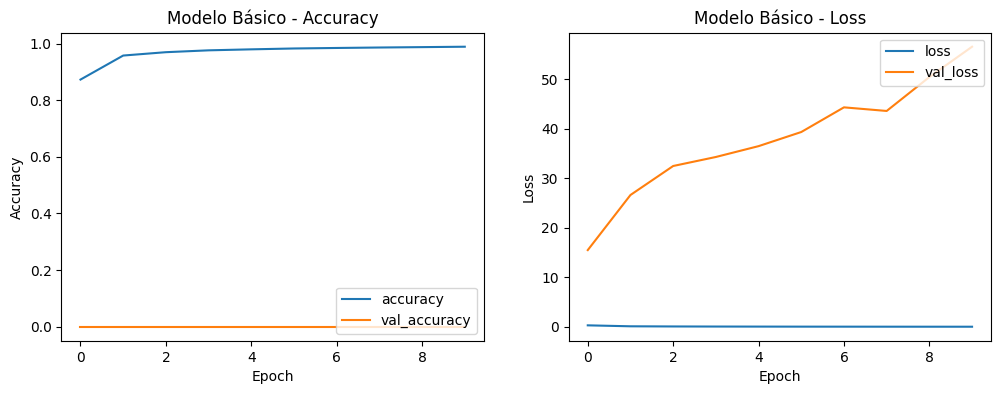

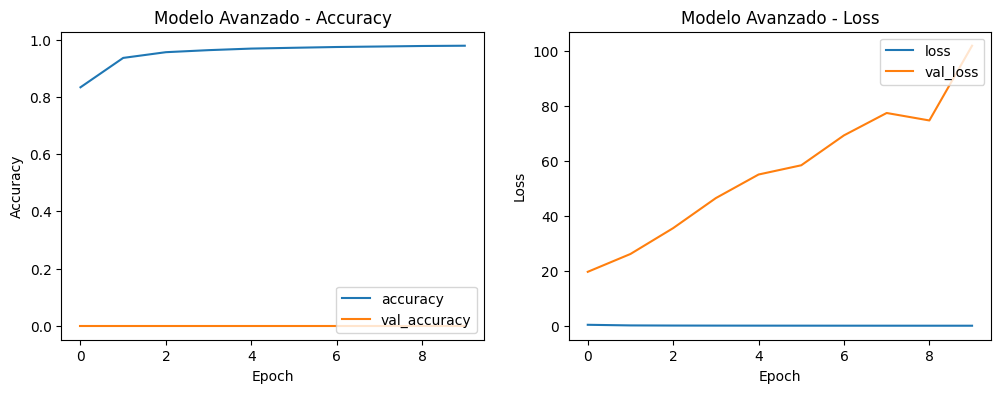

In [14]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    plt.show()

plot_history(history_basic, 'Modelo Básico')
plot_history(history_advanced, 'Modelo Avanzado')


# Creación de un modelo de una red neuronal simple

c:\Users\mague\Downloads\Lab4DataScience\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6448 - loss: 0.7940 - val_accuracy: 0.0000e+00 - val_loss: 19.3963
Epoch 2/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7508 - loss: 0.5625 - val_accuracy: 0.0000e+00 - val_loss: 30.4965
Epoch 3/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7795 - loss: 0.5026 - val_accuracy: 0.0000e+00 - val_loss: 40.0790
Epoch 4/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7986 - loss: 0.4628 - val_accuracy: 0.0000e+00 - val_loss: 38.4198
Epoch 5/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8113 - loss: 0.4378 - val_accuracy: 0.0000e+00 - val_loss: 40.4297
Epoch 6/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8206 - loss: 0.4181 - val_accuracy: 0.0000e+00 - val_loss: 43.6461
Epoch 7/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.8267 - loss: 0.4050 - val_accuracy: 0.0000e+00 - val_loss: 47.5092
Epoch 8/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 18s 2m

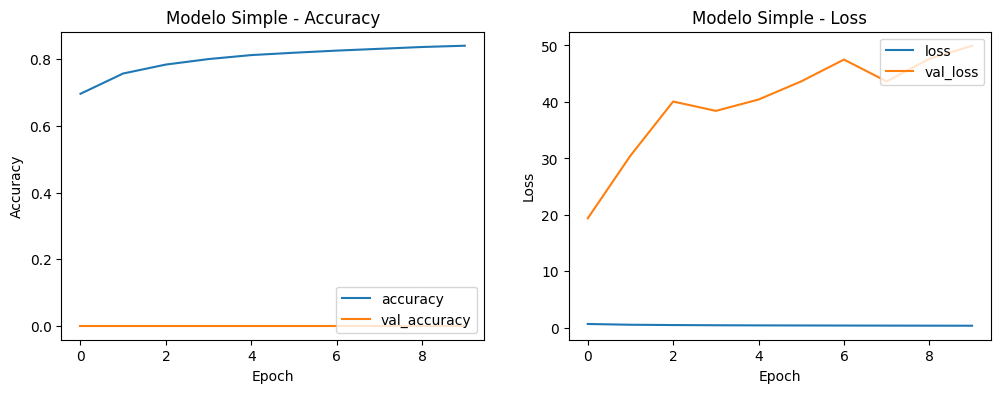

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def create_simple_nn():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Crear y entrenar el modelo de red neuronal simple
simple_nn = create_simple_nn()

# Entrenar el modelo simple
history_simple = simple_nn.fit(train_images, train_labels_one_hot, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluar el modelo simple
test_loss_simple, test_accuracy_simple = simple_nn.evaluate(test_images, test_labels_one_hot, verbose=1)
print(f'Accuracy del Modelo Simple: {test_accuracy_simple:.4f}')

# Graficar los resultados
plot_history(history_simple, 'Modelo Simple')
